In [ ]:
import sys
!{sys.executable} -m pip install tensorflow --user
!{sys.executable} -m pip install imageio --user

In [45]:
!{sys.executable} -m pip show tensorflow

Name: tensorflow
Version: 2.5.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: c:\users\alif-\appdata\roaming\python\python38\site-packages
Requires: google-pasta, numpy, astunparse, typing-extensions, termcolor, gast, tensorboard, tensorflow-estimator, wheel, six, opt-einsum, absl-py, keras-nightly, h5py, keras-preprocessing, grpcio, flatbuffers, protobuf, wrapt
Required-by: 


In [46]:
import os
os.getcwd() 

'C:\\Users\\alif-\\Projects\\deep-learning\\tf-hand-signs'

In [ ]:
import sys
sys.path.append('C:\\users\\alif-\\appdata\\roaming\\python\\python38\\site-packages')
sys.path.append('C:\\users\\alif-\\anaconda3\\lib\\site-packages')

In [ ]:
import h5py
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.python.framework.ops import EagerTensor
from tensorflow.python.ops.resource_variable_ops import ResourceVariable
import time
import imageio

In [55]:
train_set = h5py.File('data/train_signs.h5', "r")
test_set = h5py.File('data/test_signs.h5', "r")

In [61]:
[key for key in train_set.keys()]

['list_classes', 'test_set_x', 'test_set_y']

In [57]:
dset = train_set['train_set_x']
data = np.array(dset[:,:,:])
print(data[1].shape)

(64, 64, 3)


In [53]:
file = 'test.png' # or .jpg
imageio.imwrite(file, data[1])

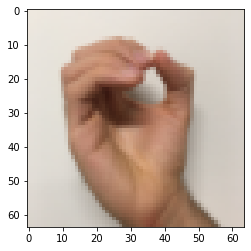

In [58]:
plt.imshow(data[1])

In [70]:
train_x = tf.data.Dataset.from_tensor_slices(train_data['train_set_x'])
train_y = tf.data.Dataset.from_tensor_slices(train_data['train_set_y'])

In [71]:
[key for key in test_set.keys()]

['list_classes', 'test_set_x', 'test_set_y']

In [72]:
test_x = tf.data.Dataset.from_tensor_slices(test_data['test_set_x'])
test_y = tf.data.Dataset.from_tensor_slices(test_data['test_set_y'])

In [73]:
type(train_x)

tensorflow.python.data.ops.dataset_ops.TensorSliceDataset

In [74]:
print(train_y.element_spec)

TensorSpec(shape=(), dtype=tf.int64, name=None)


In [75]:
for element in train_x:
    print(element)
    break

tf.Tensor(
[[[227 220 214]
  [227 221 215]
  [227 222 215]
  ...
  [232 230 224]
  [231 229 222]
  [230 229 221]]

 [[227 221 214]
  [227 221 215]
  [228 221 215]
  ...
  [232 230 224]
  [231 229 222]
  [231 229 221]]

 [[227 221 214]
  [227 221 214]
  [227 221 215]
  ...
  [232 230 224]
  [231 229 223]
  [230 229 221]]

 ...

 [[119  81  51]
  [124  85  55]
  [127  87  58]
  ...
  [210 211 211]
  [211 212 210]
  [210 211 210]]

 [[119  79  51]
  [124  84  55]
  [126  85  56]
  ...
  [210 211 210]
  [210 211 210]
  [209 210 209]]

 [[119  81  51]
  [123  83  55]
  [122  82  54]
  ...
  [209 210 210]
  [209 210 209]
  [208 209 209]]], shape=(64, 64, 3), dtype=uint8)


In [78]:
def unroll(image):
    image = tf.cast(image, tf.float32) / 256.0
    image = tf.reshape(image, [-1,1])
    return image

In [79]:
unroll_train = train_x.map(unroll)
unroll_test = test_x.map(unroll)

In [80]:
unroll_train.element_spec

TensorSpec(shape=(12288, 1), dtype=tf.float32, name=None)

In [82]:
print(next(iter(unroll_train)))

tf.Tensor(
[[0.88671875]
 [0.859375  ]
 [0.8359375 ]
 ...
 [0.8125    ]
 [0.81640625]
 [0.81640625]], shape=(12288, 1), dtype=float32)
